
Object Detection From TF2 Saved Model
=====================================


In [1]:
import os
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

### In this section, fill in the paths

In [ ]:
# In here, put the paths to the images you wanna test
IMAGE_PATHS = ['train.jpg', 'test.jpg']
print('IMAGE_PATHS = {}'.format(IMAGE_PATHS))

# In here, put the paths to the model you wanna test
PATH_TO_MODEL_DIR='exported-models/my-ssd-mobilenet-v2'
print('PATH_TO_MODEL_DIR'.format(PATH_TO_MODEL_DIR))

# In here, put the paths to the label map you used to train the model
PATH_TO_LABELS='annotations/label_map.pbtxt'
print('PATH_TO_LABELS'.format(PATH_TO_LABELS))

In [2]:
%matplotlib inline

warnings.filterwarnings('ignore')

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
print('PATH_TO_SAVED_MODEL'.format(PATH_TO_SAVED_MODEL))

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

print('category_index')
print(category_index)

IMAGE_PATHS = ['train.jpg', 'test.jpg']
PATH_TO_MODEL_DIR
PATH_TO_LABELS
PATH_TO_SAVED_MODEL
category_index
{1: {'id': 1, 'name': 'apple'}, 2: {'id': 2, 'name': 'banana'}}


In [3]:
# Load model

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 7.738495588302612 seconds


Running inference for train.jpg... Done
Running inference for test.jpg... Done


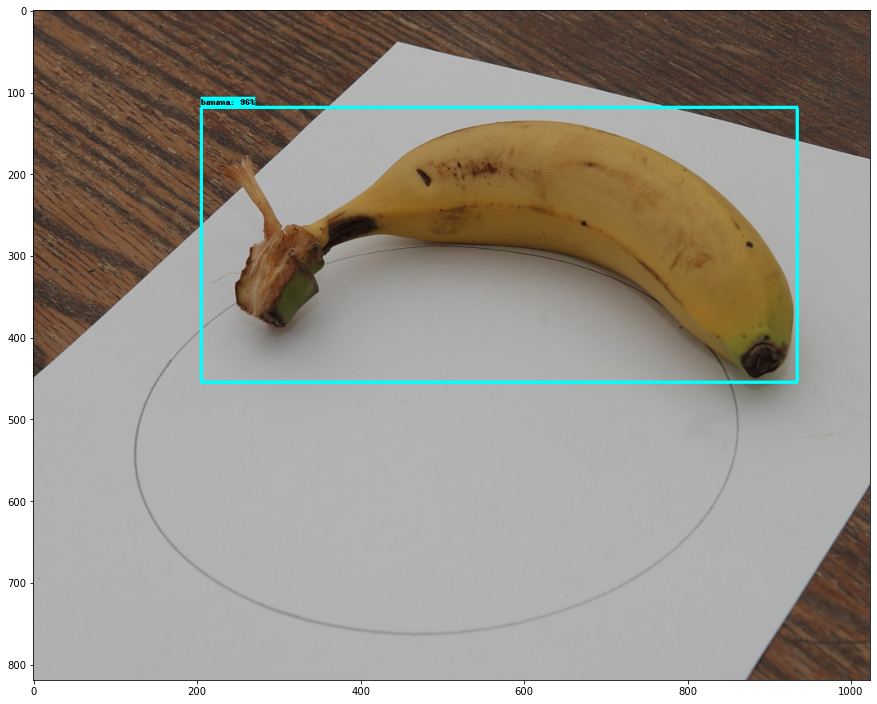

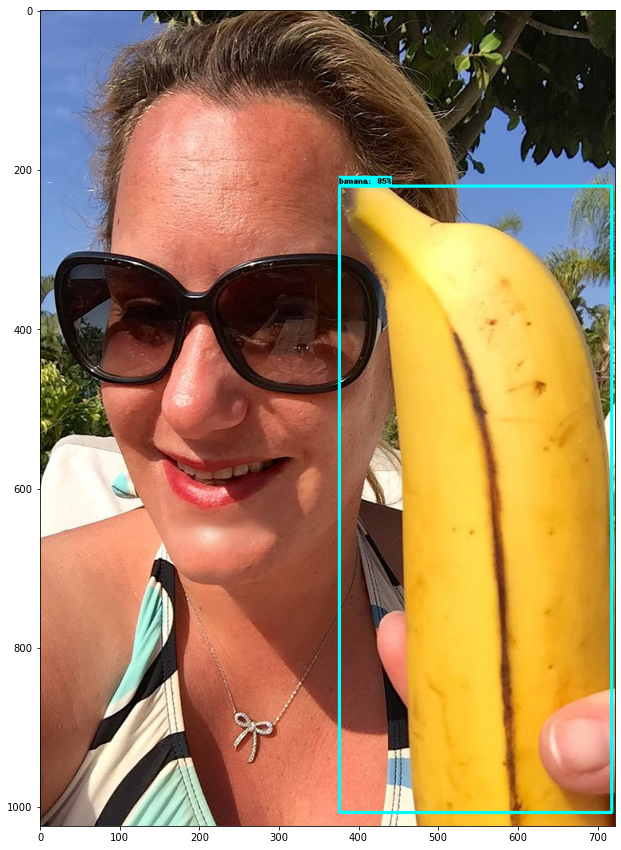

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path).convert('RGB'))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=100,
          min_score_thresh=0.20,
          agnostic_mode=False)

    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2